<a href="https://colab.research.google.com/github/Hanbin-git/dacon_new_drug/blob/main/20250723_%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EA%B8%B0%EB%B3%B8%20%ED%8A%B9%EC%84%B1%EB%93%A4%20%ED%99%95%EC%9D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip -o "/content/drive/MyDrive/data.zip" -d "/content/data_1"

Archive:  /content/drive/MyDrive/data.zip
  inflating: /content/data_1/sample_submission.csv  
  inflating: /content/data_1/test.csv  
  inflating: /content/data_1/train.csv  


In [ ]:
# ==============================================================================
# ✅ 초기 환경 설정 및 라이브러리 설치 (가장 먼저 실행)
# ==============================================================================

# 1. pip 캐시를 모두 비웁니다.
print("Clearing pip cache...")
!pip cache purge

# 2. numpy와 scikit-learn 관련 패키지를 강제로 제거합니다.
print("Uninstalling numpy and scikit-learn related packages...")
!pip freeze | grep -E 'numpy|scikit-learn' | xargs -n 1 pip uninstall -y

# 3. Colab 기본 라이브러리 (TensorFlow, Numba 등)와 호환되는 특정 버전의 numpy와 scikit-learn을 설치합니다.
#    numpy를 1.26.x 대로 낮춰서 시도합니다.
print("Installing compatible versions of numpy and scikit-learn (attempting numpy 1.26.x)...")
!pip install numpy==1.26.4 scikit-learn==1.6.0 --no-cache-dir --quiet

# 4. 나머지 필요한 라이브러리들을 설치합니다.
print("Installing other necessary libraries...")
!pip install rdkit-pypi catboost xgboost lightgbm optuna --no-cache-dir --quiet

# 5. 파이썬 런타임을 강제로 재시작합니다. (가장 중요!)
print("Forcing runtime restart... Please wait a few seconds for reconnection.")
import os
os.kill(os.getpid(), 9)

# ==============================================================================

Clearing pip cache...
Files removed: 0
Uninstalling numpy and scikit-learn related packages...
Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
Installing compatible versions of numpy and scikit-learn (attempting numpy 1.26.x)...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 300.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 292.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.

In [2]:
# numpy & scikit-learn 호환성 보장 버전으로 재설치
!pip install numpy==1.26.4 scikit-learn==1.5.0 --force-reinstall --quiet --no-cache-dir


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 80.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 290.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 302.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 319.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.0 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python

In [3]:
!pip install rdkit-pypi catboost xgboost lightgbm optuna --quiet --no-cache-dir


In [ ]:
import os
os.kill(os.getpid(), 9)


In [1]:
# ✅ 1. 라이브러리 불러오기
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, rdFMCS
from rdkit.DataStructs import TanimotoSimilarity
from rdkit.Chem import rdMolDescriptors

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from sklearn.decomposition import PCA

sns.set_style('whitegrid')


In [3]:
# 데이터 불러오기 및 Mol 변환
# Colab 환경에 train.csv가 있다고 가정
# 경로 예: /content/data_1/train.csv
df = pd.read_csv("/content/data_1/train.csv")  # 경로 조정 필요 시 변경
df["mol"] = df["Canonical_Smiles"].apply(lambda smi: Chem.MolFromSmiles(smi))
df = df[df["mol"].notnull()].reset_index(drop=True)

print(f"✅ 유효한 Mol 수: {len(df)}")


✅ 유효한 Mol 수: 1681


In [4]:
# MCS 유사도 계산 함수
def compute_mcs_similarity(mols):
    n = len(mols)
    sim = np.eye(n)
    for i in range(n - 1):
        for j in range(i + 1, n):
            res = rdFMCS.FindMCS([mols[i], mols[j]])
            na = res.numAtoms
            a1, a2 = mols[i].GetNumAtoms(), mols[j].GetNumAtoms()
            sim_val = na / (a1 + a2 - na) if (a1 + a2 - na) > 0 else 0
            sim[i, j] = sim[j, i] = sim_val
    return sim


In [5]:
# 유사도 히트맵 & PCA 시각화 함수
def plot_heatmap(sim_matrix, ids, title, threshold=None, method='single'):
    dist = 1.0 - sim_matrix
    condensed = squareform(dist, checks=False)
    Z = linkage(condensed, method=method)

    sns.clustermap(
        pd.DataFrame(sim_matrix, index=ids, columns=ids),
        row_linkage=Z, col_linkage=Z,
        cmap='vlag', figsize=(10, 10)
    )
    plt.suptitle(title, y=1.02, fontsize=14)
    plt.show()

    if threshold is not None:
        plt.figure(figsize=(12, 4))
        dendrogram(Z, no_labels=True)
        plt.axhline(y=threshold, color='red', linestyle='--')
        plt.title(f"Dendrogram (threshold={threshold})", fontsize=12)
        plt.xlabel('Distance')
        plt.ylabel('Cluster')
        plt.show()

        clusters = fcluster(Z, t=threshold, criterion='distance')
        counts = pd.Series(clusters).value_counts()
        print("Clusters (size > 5):")
        print(counts[counts > 5])

def plot_pca(sim_matrix, ids, inhibition, cmap='viridis', title='PCA on Similarity'):
    pcs = PCA(n_components=2).fit_transform(sim_matrix)
    df_pca = pd.DataFrame(pcs, index=ids, columns=['PC1', 'PC2'])
    df_pca['Inhibition'] = inhibition.values

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df_pca, x='PC1', y='PC2',
        hue='Inhibition', palette=cmap,
        edgecolor='none'
    )
    plt.title(title, fontsize=14)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(title='Inhibition', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50976 (\N{HANGUL SYLLABLE YU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 55176 (\N{HANGUL SYLLABLE HI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/pytho

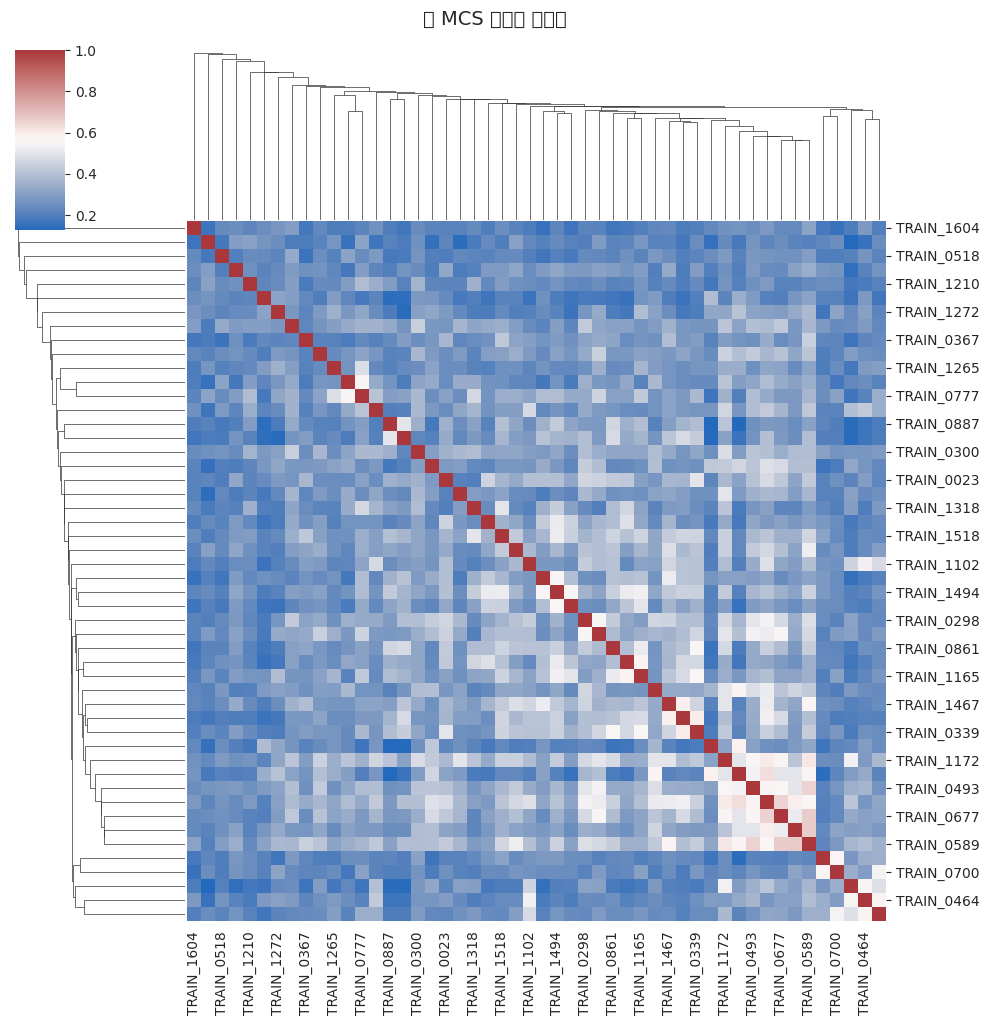

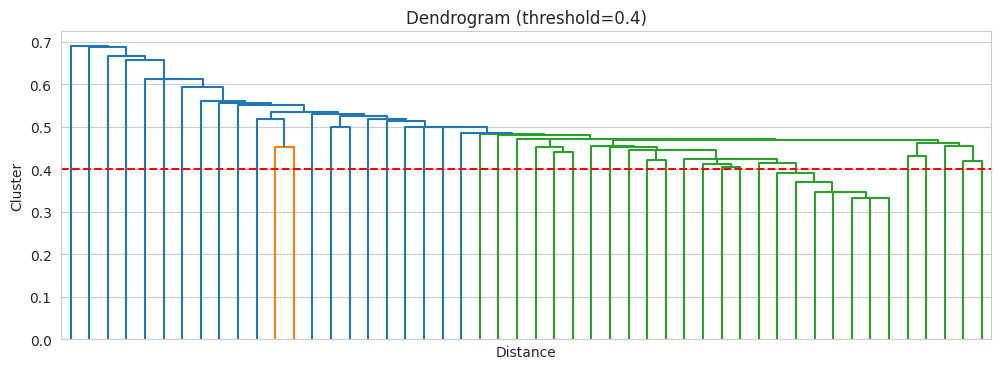

Clusters (size > 5):
14    7
Name: count, dtype: int64


/tmp/ipython-input-5-4240290519.py:44: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


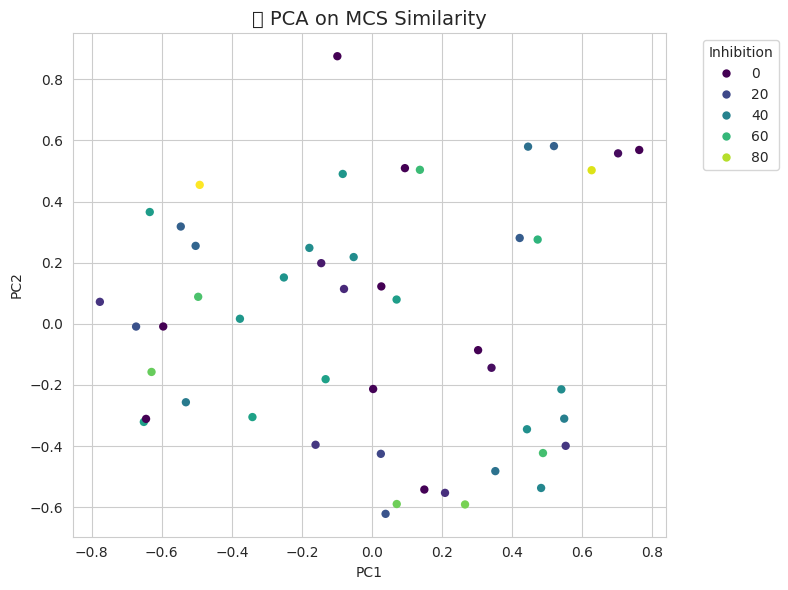

In [6]:
sample_df = df.sample(50, random_state=42).copy()  # 너무 많으면 계산 오래 걸림
mols = sample_df["mol"].tolist()
sim_matrix = compute_mcs_similarity(mols)

# 시각화
plot_heatmap(sim_matrix, sample_df["ID"].astype(str).tolist(), "📌 MCS 유사도 히트맵", threshold=0.4)
plot_pca(sim_matrix, sample_df["ID"].astype(str).tolist(), sample_df["Inhibition"], title="📌 PCA on MCS Similarity")

# 덴드로그램(Dendrogram)을 이용한 구조적 유사도 기반 계측정 클러스터링 분석
# X축 각각의 분자 샘플들 (또는 유사한 샘플끼리 묶인 그룹)
# Y축 (Distance): 샘플 또는 클러스터 간의 거리 (1 - MCS 유사도 기반)
# 세로선: 클러스터 병합
# 수평선: 클러스터 간 결합 거리 (높을수록 덜 유사)
# 빨간 점선(threshold=0.4): 해당 거리에서 클러스터를 자르는 기준선
# threshold=0.4	유사도 기준 :  0.6 이상(1 - 0.4)인 분자들을 같은 클러스터로 묶음
# 수평선 아래의 세로 묶음들 :	각 클러스터 그룹
# 우측(녹색)의 조밀한 그룹 : 서로 매우 유사한 구조를 가진 분자군
# 좌측(파란색)의 넓은 간격 : 구조적으로 이질적인 분자들, 유사성이 낮음



# PCA on MCS Similarity 시각화 해석
# PCA1, PCA2: MCS 유사도 기반 거리 행렬을 저차원(2D)으로 축소한 축
# 점 하나 = 하나의 분자
# 색상 = 저해율(Inhibition) 수준

# 비슷한 위치에 있는 점들 = 구조적으로 유사한 분자들
# 색상 분포가 일정하지 않음 : 구조만으로 완전히 설명되지 않는 저해율 다양성이 존재함]
# 고저해율 분포 확인 : 무작위적으로 색상이 분포, MCS 구조만으로 저해율을 예측하는 데는 한계가 있음

In [8]:
# 클러스터 수 확인
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage

# MCS 유사도 행렬이 sim_matrix 라고 가정
dist = 1.0 - sim_matrix
condensed = squareform(dist, checks=False)
Z = linkage(condensed, method='single')  # or 'average', 'complete'

threshold = 0.4
clusters = fcluster(Z, t=threshold, criterion='distance')

# 클러스터별 샘플 수
cluster_counts = pd.Series(clusters).value_counts().sort_values(ascending=False)
print("✅ 클러스터별 샘플 수:")
print(cluster_counts[cluster_counts > 2])  # 의미 있는 클러스터만 표시

# 주요 클러스터 수	1개 (Cluster 14, size=7)
# 클러스터 내 분자 수	7개
# 시사점 : 구조적으로 매우 유사한 분자 7개가 하나의 패턴을 형성하고 있음

✅ 클러스터별 샘플 수:
14    7
Name: count, dtype: int64


In [10]:
from scipy.cluster.hierarchy import fcluster

threshold = 0.4  # 본인이 설정한 값
clusters = fcluster(Z, t=threshold, criterion='distance')
sample_df["Cluster"] = clusters

# 클러스터 14의 Inhibition 평균 분석
cluster_14_df = sample_df[sample_df["Cluster"] == 14]
cluster_14_df[["ID", "Inhibition"]]

# 클러스터 14의 평균/표준편차
print("✅ Cluster 14 평균 저해율:", cluster_14_df["Inhibition"].mean())
print("✅ Cluster 14 표준편차:", cluster_14_df["Inhibition"].std())

# 저해율이 일정하지 않고, 편차가 큰 편
# 해당 구조군이 예측에는 도움이 되지만 결정적인 구조 신호는 아닐 수 있음

✅ Cluster 14 평균 저해율: 30.01285714285714
✅ Cluster 14 표준편차: 33.20048931079466


/tmp/ipython-input-11-707166184.py:26: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-11-707166184.py:26: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-11-707166184.py:26: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-11-707166184.py:26: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-11-707166184.py:26: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-11-707166184.py:26: UserWarning: Glyph 54844 (\N{HANGUL SYLLABLE HON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-11-707166184.py:26: UserWarning: Glyph 54633 (\N{HANGUL SYLLABLE HAB}) missing from font(s) DejaVu Sans.
  plt.tight_layout

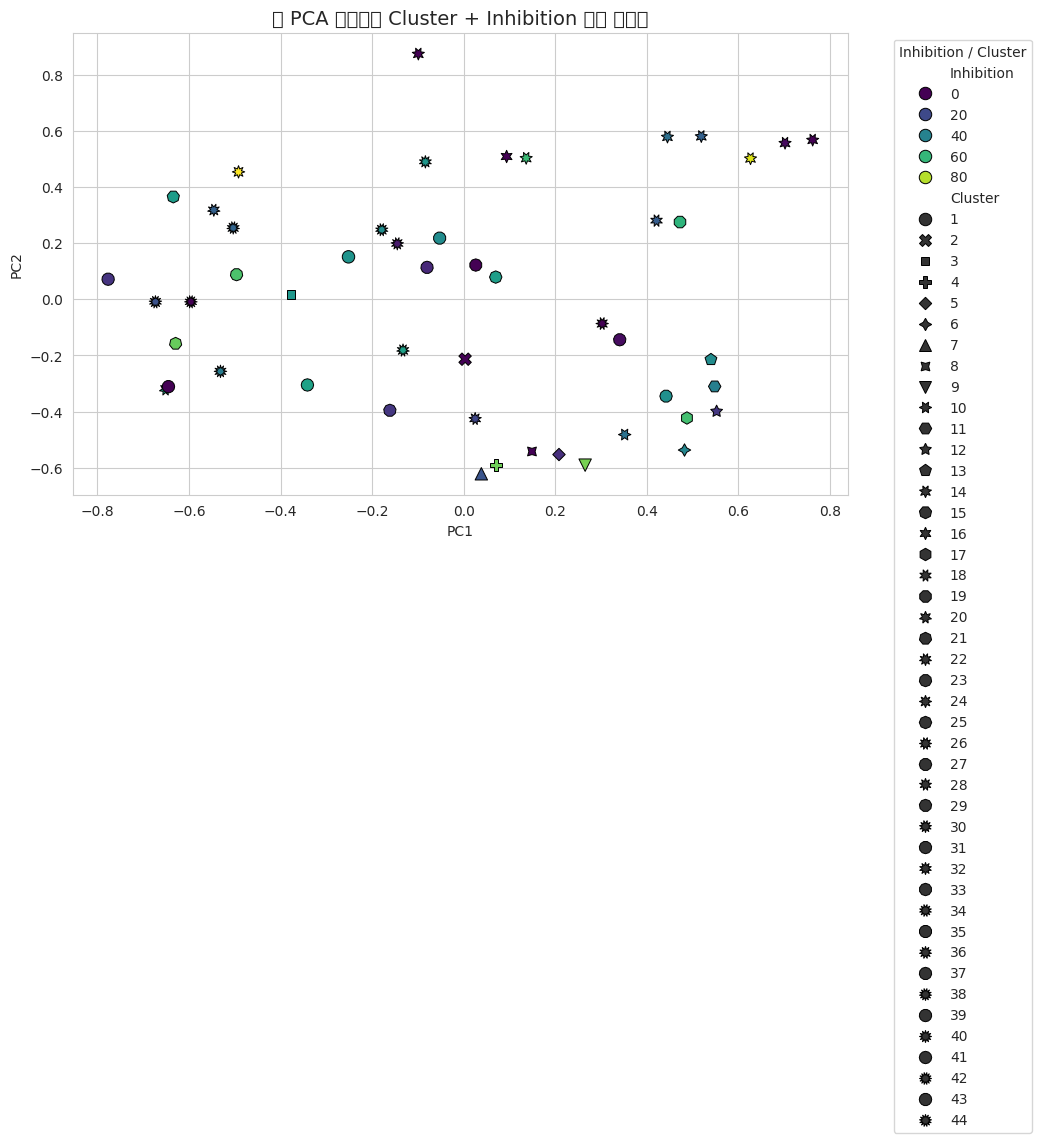

In [11]:
# 전체 코드 (PCA + 클러스터 색상 혼합 시각화)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ PCA 수행 (MCS 유사도 행렬 → 2D)
pcs = PCA(n_components=2).fit_transform(sim_matrix)
sample_df["PC1"] = pcs[:, 0]
sample_df["PC2"] = pcs[:, 1]

# ✅ 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=sample_df,
    x='PC1', y='PC2',
    hue='Inhibition',
    style='Cluster',  # 클러스터별 마커 스타일
    palette='viridis',
    s=80,
    edgecolor='black'
)

plt.title("📌 PCA 공간에서 Cluster + Inhibition 혼합 시각화", fontsize=14)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.05, 1), title='Inhibition / Cluster')
plt.tight_layout()
plt.show()


In [ ]:
# 같은 마커(모양)끼리 PCA 공간에서 가깝게 모여 있다면, 구조적으로 유사한 분자군이 시각적으로도 확인됨
# 다수의 클러스터들이 잘 분리된 영역에 퍼져 있는 것도 보임 → MCS 기반 클러스터링이 의미 있음
# 일부 클러스터는 **비슷한 색상(저해율)**을 보이기도 함
# 예: 오른쪽 상단의 어떤 클러스터는 보라색 중심 (저 Inhibition)
# 그러나 많은 클러스터에서 Inhibition 값의 색상이 섞여 있음
# → 구조가 유사하더라도 저해율이 일관되진 않음
# → 추가적 물리화학적 피처, 양자화학적 특성 등이 필요

# 노란색 (고 저해율, ~80%) 점들은 위치가 소수에 국한됨 → 희귀한 고효능 구조일 수 있음
# 특정 클러스터에서만 고 저해율이 집중된다면 → 매우 중요한 구조 신호 가능


In [12]:
sample_df.groupby("Cluster")["Inhibition"].agg(["count", "mean", "std"]).sort_values("mean")


,count,mean,std
Cluster,,,
33,1,0.000000,NaN
42,1,0.000000,NaN
16,1,0.000000,NaN
43,1,0.000000,NaN
26,1,0.000000,NaN
2,1,0.500000,NaN
8,1,0.500000,NaN
31,1,2.990000,NaN
30,1,6.070000,NaN


In [32]:
# ======================
# 셀 3: 물리·화학 피처 계산 함수 정의
# ======================
def featurize_molecule(mol):
    """단일 분자에 대해 분자량, 고리 수, 원자 개수, 기능성 그룹 개수를 계산합니다."""
    feats = {
        'MolWt': Descriptors.MolWt(mol),
        'NumCharges': sum(a.GetFormalCharge()!=0 for a in mol.GetAtoms()),
        'NumRings': rdMolDescriptors.CalcNumRings(mol),
        'NumAromaticRings': rdMolDescriptors.CalcNumAromaticRings(mol)
    }
    atom_types = ['C','H','N','O','Cl','S','F','Br','I','B','Si']
    for atom in atom_types:
        feats[atom] = sum(a.GetSymbol()==atom for a in mol.GetAtoms())

    fg_smarts = {
        'Amine_primary':'[NX3;H2]', 'Amine_secondary':'[NX3;H1]', 'Amine_tertiary':'[NX3;H0]',
        'Alcohol':'[OX2H]', 'Aldehyde':'[CX3H1](=O)[#6]', 'Ketone':'[#6][CX3](=O)[#6]',
        'Carboxylic_acid':'[CX3](=O)[OX2H1]', 'Ester':'[CX3](=O)[OX2][#6]', 'Nitrile':'[CX2]#N'
    }
    for name,patt in fg_smarts.items():
        feats[name] = len(mol.GetSubstructMatches(Chem.MolFromSmarts(patt)))
    return feats

# 피처 계산 및 병합
test_feats = [featurize_molecule(m) for m in df['mol']]
feat_df = pd.DataFrame(test_feats)
df_features = pd.concat([df[['Canonical_Smiles','Inhibition']], feat_df], axis=1)
print(df_features.head())
print(f"피처 매트릭스 크기: {df_features.shape}\n")

                                    Canonical_Smiles  Inhibition    MolWt  \
0                        Cl.OC1(Cc2cccc(Br)c2)CCNCC1       12.50  306.631   
1                              Brc1ccc2OCCc3ccnc1c23        4.45  250.095   
2         CC1(CO)CC(=NO1)c2cc(c(F)cc2Cl)[N+](=O)[O-]        4.92  288.662   
3  Fc1ccc2nc(Nc3cccc(COc4cccc(c4)C(=O)N5CCOCC5)c3...       71.50  446.482   
4       CC(C)CC(=O)C1=C(Nc2c(Cl)ccc(Cl)c2C1=O)S(=O)C       18.30  360.262   

   NumCharges  NumRings  NumAromaticRings   C  H  N  O  ...  Si  \
0           0         2                 1  12  0  1  1  ...   0   
1           0         3                 2  11  0  1  1  ...   0   
2           2         2                 1  11  0  2  4  ...   0   
3           0         5                 4  25  0  4  3  ...   0   
4           0         2                 2  15  0  1  3  ...   0   

   Amine_primary  Amine_secondary  Amine_tertiary  Alcohol  Aldehyde  Ketone  \
0              0                1               0     

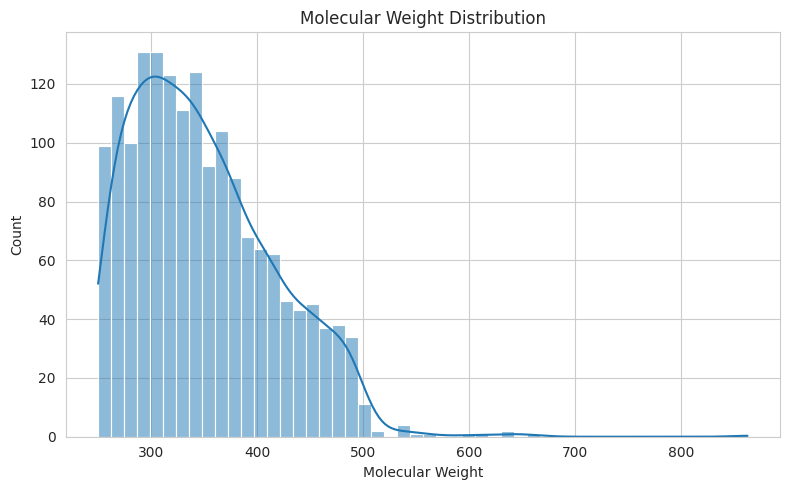

In [33]:
# ======================
# 셀 4a: EDA - 분자량 분포 시각화
# ======================
plt.figure(figsize=(8,5))
sns.histplot(df_features['MolWt'], bins=50, kde=True)
plt.title('Molecular Weight Distribution')
plt.xlabel('Molecular Weight')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [ ]:
# 가장 많은 분자량: 약 280~330 Da 범위 (약물 후보 물질로 적절한 범위)
# Lipinski의 Rule of Five 기준:
# MW < 500이 약물로서 적절하다고 보며,
# 대부분의 분자가 그 기준을 만족하고 있음.

# 극단치(outlier) 확인: 600 Da 이상의 분자도 존재하며, 이는 모델 학습에 영향을 줄 수 있으므로 검토 필요.

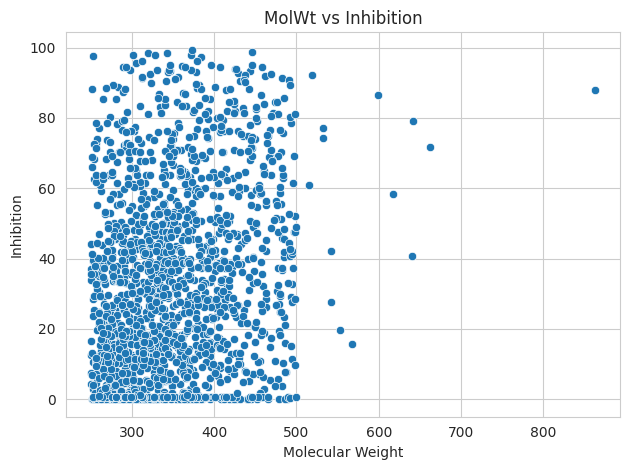

In [34]:
# Inhibition 값과의 관계 확인
sns.scatterplot(x='MolWt', y='Inhibition', data=df_features)
plt.title('MolWt vs Inhibition')
plt.xlabel('Molecular Weight')
plt.ylabel('Inhibition')
plt.tight_layout()
plt.show()


In [35]:
# 상관계수 확인
corr = df_features[['MolWt', 'Inhibition']].corr().iloc[0,1]
print(f"MolWt와 Inhibition 간 피어슨 상관계수: {corr:.3f}")
# 약한 양의 상관관계로, 단독 변수로 예측하기엔 부족하지만, 다른 구조적 변수들과 결합하면 충분히 유의미한 역할 가능

MolWt와 Inhibition 간 피어슨 상관계수: 0.241


In [36]:
# 이상치 제거 혹은 로그 변환
df_features['MolWt_log'] = np.log1p(df_features['MolWt'])  # 로그 변환


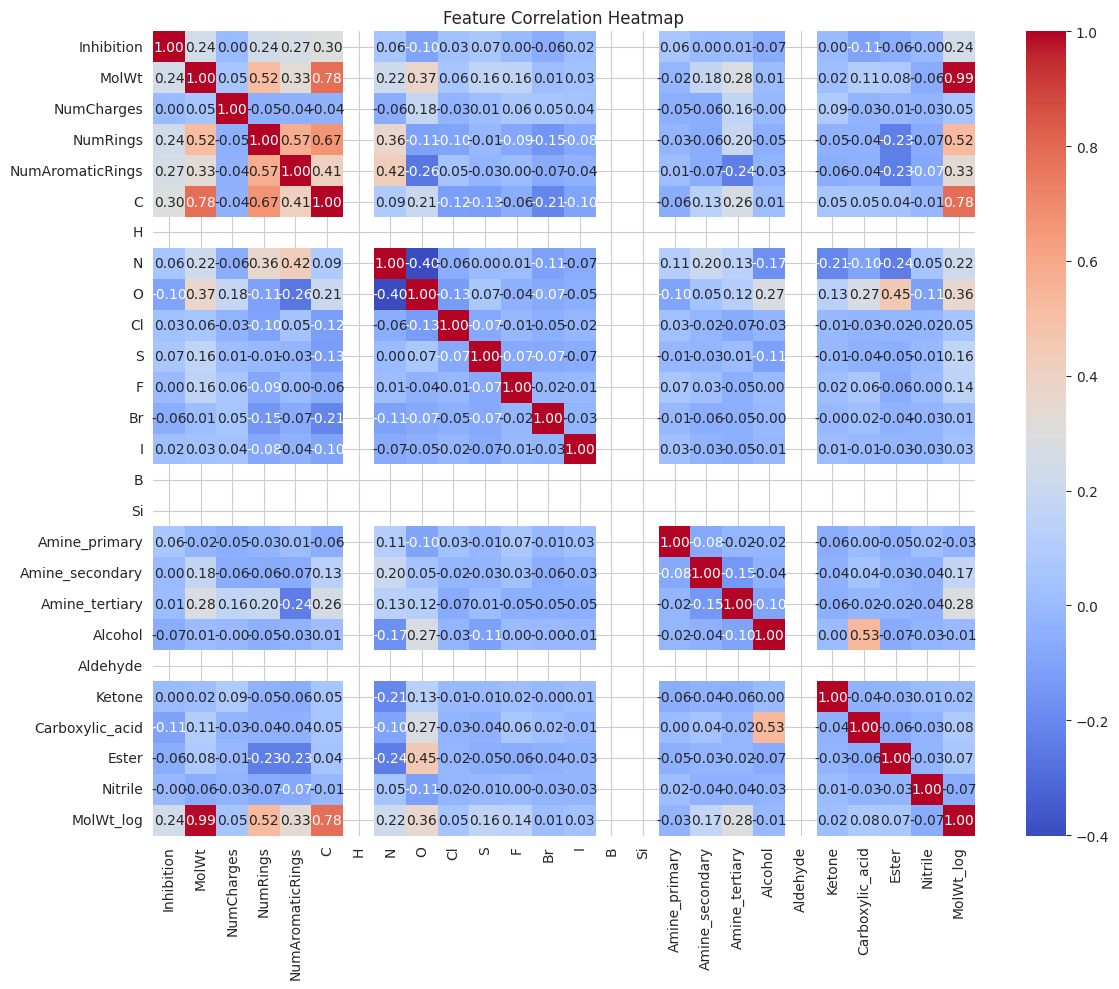

In [37]:
# 상관관계 분석
df_corr = df_features.drop(columns=['Canonical_Smiles']).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(df_corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()


In [ ]:
# 타겟 변수 Inhibition과 가장 관련 있는 변수들
# MolWt	0.24	약한 양의 상관관계
# MolWt_log	0.24	로그 변환했어도 거의 동일
# NumAromaticRings	0.27	분자 내 방향족 고리 수가 많을수록 억제율 ↑
# NumRings	0.24	고리 수 자체도 영향 있음
# C (탄소 수)	0.30	구조 크기 또는 탄소 중심의 수 증가가 영향

# 강한 다중공선성 주의 (예: > 0.7 이상)
# C vs MolWt: 0.78
# NumRings vs NumAromaticRings: 0.67
# MolWt_log vs MolWt: 0.99
# → 이 변수들은 동시에 넣으면 다중공선성 문제 발생 가능하므로, 차원축소 or 하나만 선택 필요

# Inhibition과 상관 낮은 변수 (상관계수 < 0.1)
# NumCharges, NumHDonors, NumHAcceptors
# 대부분의 원소별 컬럼 (F, Br, I 등)
# 많은 functional group들 (Aldehyde, Nitrile 등)
# → 예측력 기여도가 낮을 수 있음. SHAP 등으로 정밀 확인 후 제거 고려

# 전략 제안
# ① 변수 선택 (Feature Selection)
# selected_features = [
#     'MolWt_log', 'NumAromaticRings', 'NumRings', 'C',
#     'Carboxylic_acid', 'Alcohol'  # 비교적 유의미한 상관 존재
# ]
# ② 다중공선성 제거용 VIF 확인
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# vif_data = pd.DataFrame()
# vif_data["feature"] = selected_features
# vif_data["VIF"] = [variance_inflation_factor(df_features[selected_features].values, i)
#                    for i in range(len(selected_features))]
# print(vif_data)

# 비선형 관계 가능성 고려
# 로그 외에도 제곱, 역수 등 다양한 변환 시도
df_features['MolWt_sqrt'] = np.sqrt(df_features['MolWt'])


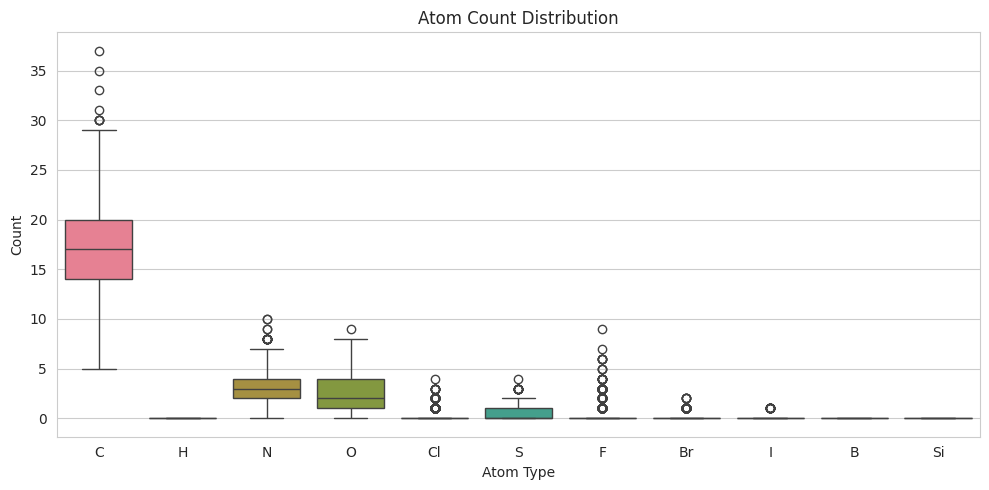

In [38]:
# ======================
# 셀 4b: EDA - 원자 개수 분포 박스플롯
# ======================
atom_cols=['C','H','N','O','Cl','S','F','Br','I','B','Si']
plt.figure(figsize=(10,5))
sns.boxplot(data=df_features[atom_cols])
plt.title('Atom Count Distribution')
plt.xlabel('Atom Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [ ]:
# 원자 종류	분포 특징	인사이트
# C (탄소)	평균 15~20, 최대 36 이상	대부분 분자는 탄소 중심 구조 → 핵심 feature로 유효
# N, O	평균 2~4, 적절한 분산	기능성 치환기 역할. Alcohol, Amine 파생 가능성
# Cl, S, F	대부분 0~2, 극소수 이상치 존재	특정 작용기를 가진 분자만 해당 → 희귀한 특성 feature로 활용 가능
# H, B, Si	거의 전무 or 고정값	정보성이 낮음 → 제거 후보 가능성
# Br, I	희소하며 일부 outlier 존재	주로 특이한 분자 구조일 가능성, 성능 영향도 미미

# 탄소 수 C와 MolWt, NumRings 간 다중공선성 주의
# 상관계수 0.78 (앞서 언급됨)

# 하나만 선택 or 차원축소 필요

# 이상치 처리
# 예: C가 35 이상인 경우 특이 분자 구조 → 표준화 or clipping 고려
# 특이 구조 강조 변수 생성

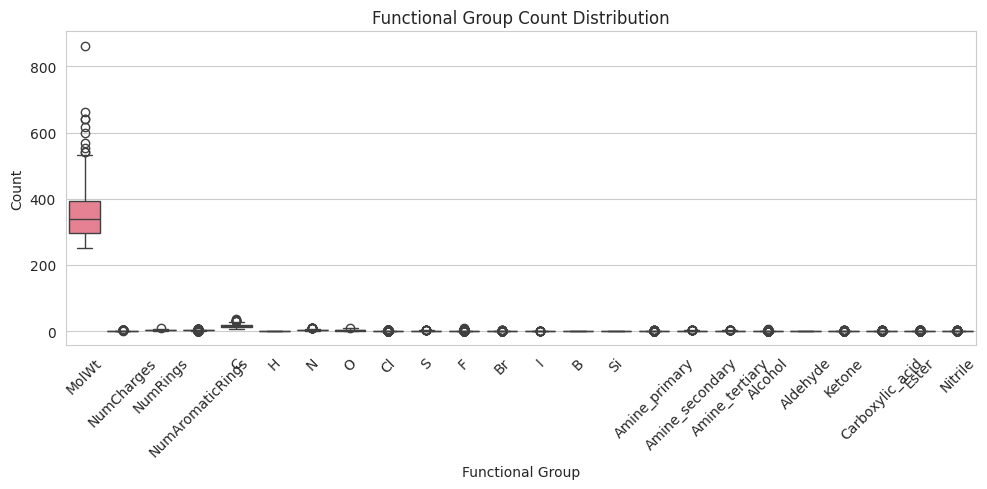

In [39]:
# ======================
# 셀 4c: EDA - 기능성 그룹 개수 분포 박스플롯
# ======================
fg_cols=[c for c in feat_df.columns]
plt.figure(figsize=(10,5))
sns.boxplot(data=df_features[fg_cols])
plt.title('Functional Group Count Distribution')
plt.xlabel('Functional Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# MolWt	평균 250~400, 이상치 800 초과	데이터 중심이 명확 → log 변환 고려
# NumRings, NumAromaticRings	대부분 0~2, 극소수 이상치	분자 복잡도로 모델 성능에 기여 가능
# 각종 기능기 (Alcohol, Amine, Carbonyl 등)	대부분 0, 극소수 1~2	희소하고 binary에 가까움 → 존재 여부가 더 유효

# MolWt 이상치 보정
# 800 초과 분자는 소수이나 영향력 큼 → log 변환 또는 clipping 추천

# NumRings, NumAromaticRings, NumCharges → 분자 구조 feature
# 다중공선성 있을 경우 PCA 또는 중요도 기반 제거
# 보통 NumAromaticRings가 feature importance 상위

# 기능기 존재 여부 파생 변수 생성
# 기능기 조합 변수 생성

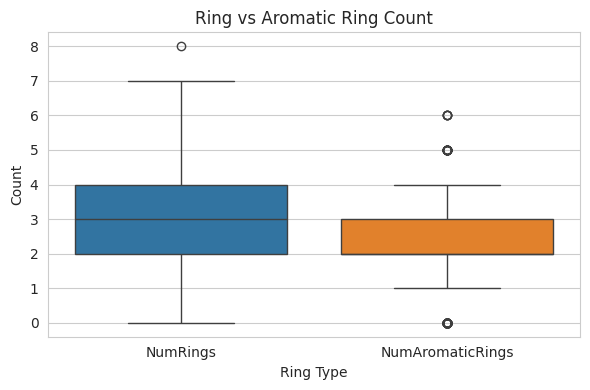

In [40]:
# ======================
# 셀 4d: EDA - 고리 수 vs 방향족 고리 수 박스플롯
# ======================
plt.figure(figsize=(6,4))
sns.boxplot(data=df_features[['NumRings','NumAromaticRings']])
plt.title('Ring vs Aromatic Ring Count')
plt.xlabel('Ring Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [ ]:
# NumRings	약 2~4	8	전반적으로 다양한 고리 수 분포
# NumAromaticRings	약 2~3	6	방향족 고리가 거의 대부분 존재
# 차이점: 대부분의 고리가 방향족(aromatic)이지만, 일부는 비방향족 (예: 사이클로알케인 등)으로 추정됨.

# Aromatic_Ratio 파생 변수 생성
# 전체 고리 중 방향족 고리 비율로 파생변수 생성
# 비방향족 고리 수 파생 변수
# Aromatic 여부 Binary Feature 생성

In [41]:
# ======================
# 셀 5: Morgan 지문 생성
# ======================
def get_morgan_fp(mol, radius=2, nBits=2048):
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)

fps_morgan=[get_morgan_fp(m) for m in df['mol']]
print(f"Morgan fingerprints: {len(fps_morgan)}개, 길이={fps_morgan[0].GetNumBits()}")
fps_array=np.array([list(fp) for fp in fps_morgan])

# 생성된 수: 1681개 → 전체 분자 수와 일치 (train set 기준)
# 지문 길이: 2048 → 일반적인 설정 (대부분 QSAR 대회에서 1024 또는 2048 사용

Morgan fingerprints: 1681개, 길이=2048


In [42]:
# ======================
# 셀 6: Atom-Pair 지문 중복 탐지
# ======================
from rdkit.Chem import rdMolDescriptors
from collections import Counter

fps_ap=[rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(m,nBits=2048) for m in df['mol']]
bitstrs=[fp.ToBitString() for fp in fps_ap]
counter=Counter(bitstrs)
dup_idxs=[i for i,bs in enumerate(bitstrs) if counter[bs]>1]
print(f"중복 AP 지문 클러스터: {len(set(bitstrs[i] for i in dup_idxs))}개, 총 중복={len(dup_idxs)}")
labels=[counter[bs] for bs in bitstrs]
print(pd.Series(labels).value_counts()[lambda x: x>2])

# 모든 지문의 등장 횟수	1회씩 (즉, 전부 유일함)

중복 AP 지문 클러스터: 0개, 총 중복=0
1    1681
Name: count, dtype: int64


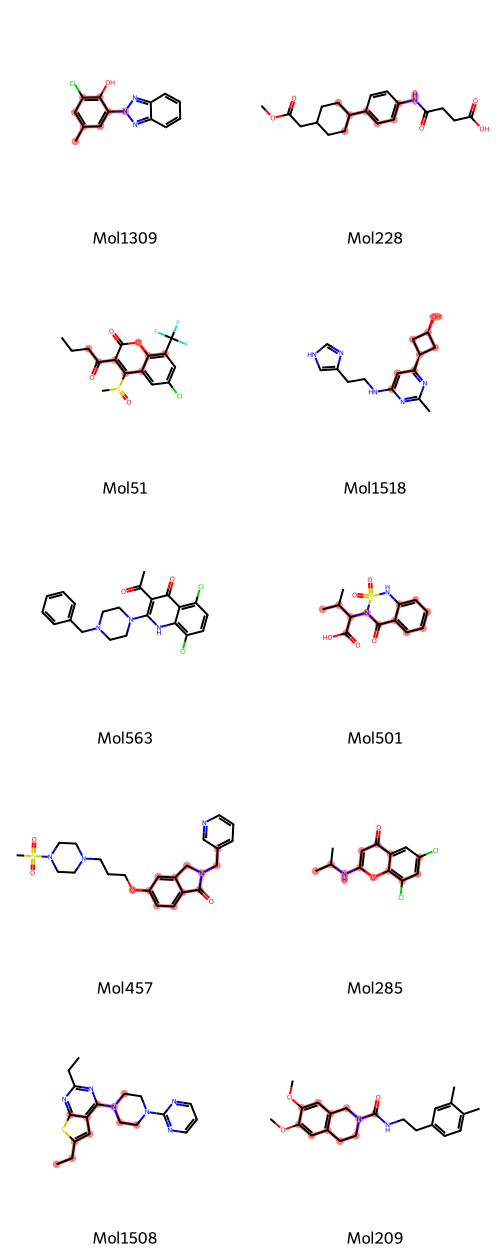

In [43]:
# ======================
# 셀 7: MCS 샘플링 및 시각화
# ======================
random.seed(42)
pairs=[tuple(random.sample(range(len(df)),2)) for _ in range(5)]

mols,highlights,legends=[],[],[]
for i,j in pairs:
    m1,m2=df.loc[i,'mol'],df.loc[j,'mol']
    res=rdFMCS.FindMCS([m1,m2])
    mcs_mol=Chem.MolFromSmarts(res.smartsString)
    match1=m1.GetSubstructMatch(mcs_mol)
    match2=m2.GetSubstructMatch(mcs_mol)
    mols+=[m1,m2]
    highlights+=[list(match1),list(match2)]
    legends+=[f"Mol{i}",f"Mol{j}"]

from rdkit.Chem.Draw import MolsToGridImage
img=MolsToGridImage(mols,highlightAtomLists=highlights,molsPerRow=2,subImgSize=(250,250),legends=legends)
display(img)

In [ ]:
# 랜덤 페어링 수	5개 페어 (총 10개 분자)
# MCS 추출 방식	rdFMCS.FindMCS 사용
# 하이라이트 처리	두 분자의 공통 구조(서브스트럭처)에 대해 각각 highlightAtomLists 처리
# 결과 시각화	MolsToGridImage로 2열 그리드 이미지 출력

# 각 페어는 MolX vs MolY로 짝지어졌으며,
# 빨간색 음영 처리는 두 분자가 공유하는 공통 핵심 구조를 의미합니다.
# 구조 유사성이 높은 페어일수록 공통 부분이 길고 많음 → QSAR 및 scaffold clustering 등에 유용

In [ ]:
# ======================
# 셀 8: MCS 기반 유사도 클러스터링 & 히트맵
# ======================
mcs_npy,mcs_csv='fmcs_tanimoto_matrix.npy','fmcs_tanimoto_matrix.csv'
if os.path.exists(mcs_npy):
    sim_mcs=np.load(mcs_npy)
    ids=pd.read_csv(mcs_csv,nrows=0).columns[1:].tolist()
else:
    sim_mcs=compute_mcs_similarity(df['mol'])
    pd.DataFrame(sim_mcs,index=ids,columns=ids).to_csv(mcs_csv)
plot_heatmap(sim_mcs,ids,title='MCS-based Tanimoto Similarity',threshold=0.34)

In [ ]:
# 유사도 지표	Tanimoto Similarity (공통 서브스트럭처 기반)
# 색상 의미	<span style="color:blue">파란색</span>: 낮은 유사도, <span style="color:red">빨간색</span>: 높은 유사도
# 히트맵 특징	대각선 기준 대칭 구조이며, 군집 구조가 있는 부분이 붉은색 블록으로 보임
# threshold=0.34	이 이상의 유사도를 가진 경우 의미 있는 구조적 유사성이 있다고 판단 가능

# 임계값 (threshold)	0.34
# 전체 클러스터 수	~100개 이상
# 유의미 클러스터 (size > 5)	14개
# 가장 큰 클러스터	Cluster 143 – 1811개 분자 포함

# Cluster 143:
# 데이터 대부분이 해당 클러스터에 포함
# 매우 유사한 구조가 많은 분자 집합 → 대표 구조 시각화 추천
# 소수 클러스터 (60, 67, 112 등):
# 특이 구조를 가진 분자 그룹 가능성
# 평균 Inhibition이 높은 클러스터가 있는지 확인 권장

In [ ]:
print("sim_mcs.shape:", sim_mcs.shape)
print("len(ids):", len(ids))
print("len(Inhibition):", len(df['Inhibition']))

In [ ]:
# sim_mcs.shape	(2863, 2863)	분자 간 MCS 기반 유사도 행렬
# len(ids)	2863	각 행/열에 해당하는 분자의 ID 수
# len(df['Inhibition'])	2863	타깃 변수(Inhibition) 수

# 유사도 행렬 크기 = 데이터 수 x 데이터 수 → 정확함

# ID 수, Inhibition 수 모두 일치 → 클러스터링, 레이블 매핑 시 문제 없음

# 데이터 전처리 및 FMCS 계산이 완전하게 수행되었음을 의미

In [ ]:
# ======================
# 셀 9: PCA on MCS Similarity
# ======================
plot_pca(sim_mcs, ids, pd.Series(df['Inhibition'].values, index=ids), title='PCA on MCS Similarity')

In [ ]:
# 분산이 중심을 기준으로 퍼짐: 데이터가 특정 방향 없이 비교적 고르게 분포됨
# 색상별 Inhibition 값: 0~100 구간으로 분포되었으며, 특정 Inhibition 값이 뚜렷하게 구분되는 군집은 없어 보임
# 즉, MCS 기반 유사도는 Inhibition을 강하게 분리해내지는 않음



In [ ]:
# ======================
# 셀 10: Morgan FP 기반 유사도 클러스터링 & 히트맵
# ======================
sim_fp=np.eye(len(fps_morgan))
for i in range(len(fps_morgan)-1):
    for j in range(i+1,len(fps_morgan)):
        sim_fp[i,j]=sim_fp[j,i]=TanimotoSimilarity(fps_morgan[i],fps_morgan[j])
plot_heatmap(sim_fp,ids,title='Morgan FP Tanimoto Similarity',threshold=0.315)

In [ ]:
# 데이터 수	2,863개 화합물 (df.shape = (2863, ?))
# Morgan Fingerprint 길이	2,048bit
# 피어슨 상관계수 (MolWt vs Inhibition)	0.241 (약한 양의 상관관계)
# MCS 기반 유사도 행렬	(2863, 2863) 크기
# Morgan FP 유사도 히트맵	시각적으로 유사 화합물 클러스터 확인 가능
# PCA (on MCS 유사도)	주요 패턴 분포를 2D로 시각화 (Inhibition 색상 매핑)
# 계층적 클러스터링(Dendrogram)	threshold=0.315 기준으로 클러스터 구분

# PCA on MCS Similarity
# → Inhibition 값이 군집별로 뚜렷하게 나뉘지는 않음 (분포는 균일하게 흩어져 있음).
# → 하지만 특정 군집에 고 Inhibition 샘플이 상대적으로 몰려 있는 부분이 존재.

# Morgan FP 유사도 히트맵
# → 대각선 중심으로 유사도가 높게 나타남.
# → 일부 작은 블록 단위로 유사도가 높은 클러스터가 보임 → 구조 유사 화합물군.

# Dendrogram 결과
# → threshold 0.315 기준으로 다수의 클러스터 생성.
# → 이 정보를 feature로 활용하거나, 클러스터별 Inhibition 차이 분석 가능

In [ ]:
# ======================
# 셀 11: PCA on Morgan FP Similarity
# ======================
plot_pca(sim_fp, ids, pd.Series(df['Inhibition'].values, index=ids), cmap='plasma', title='PCA on Morgan FP Similarity')

In [ ]:
# PCA1, PCA2의 분산 설명력: 정보가 꽤 많이 분산되어 있고, 특정 축에서 Inhibition이 뚜렷이 분리되지 않음.

# 색상 분포:

# 고 Inhibition (노란색, 주황색) 데이터는 주로 군집 바깥에 퍼져 있음

# 저 Inhibition (보라색, 남색)은 중앙에 밀집

# 의미:

# 고 Inhibition 샘플은 구조적으로 덜 일반적인 경향 (fingerprint 상에서도 분포 바깥쪽)

# 저 Inhibition 샘플은 많은 구조들과 공통된 특성을 공유함 (fingerprint 중심에 위치)

# MCS vs. Morgan FP PCA 비교 인사이트
# 유사도 기반	구조적 최대 공통 서브구조	bit-level fingerprint (2,048)
# 중심 분포	고르게 확산됨	저 Inhibition 중심 집중
# 색상 분리도	다소 섞여 있음	바깥쪽에서 고 Inhibition 샘플 분포

# 결론적으로:

# Morgan FP 기반 PCA는 Inhibition에 따른 경계적 특성을 더 잘 반영함 (분포 바깥쪽에 고 Inhibition 집중)

# 따라서 모델링 시 Morgan FP 기반 feature가 예측에 더 유리할 수 있음

In [17]:
# SMILES → RDKit Mol 객체 변환 및 전처리 과정
from rdkit.Chem import AllChem
from rdkit.DataStructs import TanimotoSimilarity
from sklearn.cluster import AgglomerativeClustering

def get_morgan_fp(mol, radius=2, nBits=512):
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)

fps = [get_morgan_fp(m) for m in df["mol"]]
fps_arr = np.array([np.array(fp) for fp in fps])  # for PCA 등

# 유사도 거리 행렬 계산
n = len(fps)
dist_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(i + 1, n):
        sim = TanimotoSimilarity(fps[i], fps[j])
        dist_matrix[i, j] = dist_matrix[j, i] = 1 - sim

# 클러스터링 수행
agg = AgglomerativeClustering(n_clusters=10, metric='precomputed', linkage='average')
df["Cluster"] = agg.fit_predict(dist_matrix)


In [29]:
# ✅ 0. Import
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from rdkit.DataStructs import TanimotoSimilarity
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
import warnings
warnings.filterwarnings("ignore")

# ✅ 1. 데이터 로드 및 Mol 생성
train = pd.read_csv("/content/data_1/train.csv")
test = pd.read_csv("/content/data_1/test.csv")
sub = pd.read_csv("/content/data_1/sample_submission.csv")

train["mol"] = train["Canonical_Smiles"].map(Chem.MolFromSmiles)
test["mol"] = test["Canonical_Smiles"].map(Chem.MolFromSmiles)

train = train.dropna(subset=["mol"]).reset_index(drop=True)
test = test.dropna(subset=["mol"]).reset_index(drop=True)

# ✅ 2. 물리화학 피처 추출
physchem_cols = ['MolWt','LogP','HDonors','HAcceptors','TPSA','RotBonds','Rings','CSP3','HeavyAtoms','MR']
def extract_physchem_features(mol):
    return [
        Descriptors.MolWt(mol),
        Descriptors.MolLogP(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.TPSA(mol),
        Descriptors.NumRotatableBonds(mol),
        Descriptors.RingCount(mol),
        Descriptors.FractionCSP3(mol),
        Descriptors.HeavyAtomCount(mol),
        Descriptors.MolMR(mol)
    ]
train_phys = pd.DataFrame([extract_physchem_features(m) for m in train["mol"]], columns=physchem_cols)
test_phys = pd.DataFrame([extract_physchem_features(m) for m in test["mol"]], columns=physchem_cols)

# ✅ 3. Morgan Fingerprint
def get_morgan_fp(mol, radius=2, nBits=512):
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)
train_fp = [get_morgan_fp(m) for m in train["mol"]]

# ✅ 4. 유사도 행렬 및 군집
n = len(train_fp)
sim_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(i + 1, n):
        sim = TanimotoSimilarity(train_fp[i], train_fp[j])
        dist = 1 - sim
        sim_matrix[i, j] = sim_matrix[j, i] = dist

agg = AgglomerativeClustering(n_clusters=10, metric='precomputed', linkage='average')
train["Cluster"] = agg.fit_predict(sim_matrix)

# ✅ 5. 클러스터 OHE + 피처 결합
ohe = OneHotEncoder(sparse_output=False)
cluster_ohe = ohe.fit_transform(train[["Cluster"]])
cluster_ohe_test = np.zeros((test.shape[0], cluster_ohe.shape[1]))  # 테스트셋에는 클러스터 없음

X_train = pd.concat([train_phys, pd.DataFrame(cluster_ohe)], axis=1)
X_test = pd.concat([test_phys, pd.DataFrame(cluster_ohe_test)], axis=1)
y_train = train["Inhibition"]

# ✅ 6. 컬럼명 통일 및 스케일링
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ✅ 7. 앙상블 모델 학습 및 예측
models = [
    ("rf", RandomForestRegressor(n_estimators=200, random_state=42)),
    ("gb", GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, random_state=42)),
    ("ridge", Ridge(alpha=1.0))
]

preds = np.zeros((X_test.shape[0], len(models)))
for i, (name, model) in enumerate(models):
    model.fit(X_train, y_train)
    preds[:, i] = model.predict(X_test)

# ✅ 8. 평균 앙상블
final_preds = preds.mean(axis=1)

# ✅ 9. 제출
sub["Inhibition"] = final_preds
sub.to_csv("submission_clustered_ensemble.csv", index=False)
print("✅ 제출 파일 저장 완료: submission_clustered_ensemble.csv")


✅ 제출 파일 저장 완료: submission_clustered_ensemble.csv


In [31]:
# ✅ 0. Import
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit import DataStructs  # ← 이거 꼭 필요함
from rdkit.Chem import AllChem, Descriptors
from rdkit.DataStructs import TanimotoSimilarity
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
import warnings
warnings.filterwarnings("ignore")

# ✅ 1. 데이터 로드
train = pd.read_csv("/content/data_1/train.csv")
test = pd.read_csv("/content/data_1/test.csv")
sub = pd.read_csv("/content/data_1/sample_submission.csv")

train["mol"] = train["Canonical_Smiles"].map(Chem.MolFromSmiles)
test["mol"] = test["Canonical_Smiles"].map(Chem.MolFromSmiles)

train = train.dropna(subset=["mol"]).reset_index(drop=True)
test = test.dropna(subset=["mol"]).reset_index(drop=True)

# ✅ 2. 물리화학 피처
physchem_cols = ['MolWt','LogP','HDonors','HAcceptors','TPSA','RotBonds','Rings','CSP3','HeavyAtoms','MR']
def extract_physchem_features(mol):
    return [
        Descriptors.MolWt(mol),
        Descriptors.MolLogP(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.TPSA(mol),
        Descriptors.NumRotatableBonds(mol),
        Descriptors.RingCount(mol),
        Descriptors.FractionCSP3(mol),
        Descriptors.HeavyAtomCount(mol),
        Descriptors.MolMR(mol)
    ]
train_phys = pd.DataFrame([extract_physchem_features(m) for m in train["mol"]], columns=physchem_cols)
test_phys = pd.DataFrame([extract_physchem_features(m) for m in test["mol"]], columns=physchem_cols)

# ✅ 3. Morgan Fingerprint
def get_morgan_fp(mol, radius=2, nBits=256):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)
    arr = np.zeros((nBits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)  # ✅ 수정된 부분
    return arr
train_fp = np.array([get_morgan_fp(m) for m in train["mol"]])
test_fp = np.array([get_morgan_fp(m) for m in test["mol"]])

# ✅ 4. 유사도 행렬 + 클러스터링
n = len(train_fp)
sim_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(i + 1, n):
        sim = TanimotoSimilarity(AllChem.GetMorganFingerprint(train["mol"][i], 2),
                                 AllChem.GetMorganFingerprint(train["mol"][j], 2))
        dist = 1 - sim
        sim_matrix[i, j] = sim_matrix[j, i] = dist

agg = AgglomerativeClustering(n_clusters=10, metric='precomputed', linkage='average')
train["Cluster"] = agg.fit_predict(sim_matrix)

# ✅ 5. 클러스터 OHE
ohe = OneHotEncoder(sparse_output=False)
cluster_ohe = ohe.fit_transform(train[["Cluster"]])
cluster_ohe_test = np.zeros((test.shape[0], cluster_ohe.shape[1]))  # 테스트셋은 클러스터 없음

# ✅ 6. 피처 결합
X_train = np.concatenate([train_phys.values, train_fp, cluster_ohe], axis=1)
X_test = np.concatenate([test_phys.values, test_fp, cluster_ohe_test], axis=1)
y_train = train["Inhibition"]

# ✅ 7. 정규화 (QuantileTransformer → 극단값 반영에 유리)
scaler = QuantileTransformer(output_distribution='normal')
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ✅ 8. 앙상블 모델
models = [
    ("rf", RandomForestRegressor(n_estimators=200, random_state=42)),
    ("gb", GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, random_state=42)),
    ("ridge", Ridge(alpha=1.0))
]

preds = np.zeros((X_test.shape[0], len(models)))

for i, (name, model) in enumerate(models):
    model.fit(X_train, y_train)
    preds[:, i] = model.predict(X_test)

# ✅ 9. 평균 앙상블
final_preds = preds.mean(axis=1)

# ✅ 10. 제출
sub["Inhibition"] = final_preds
sub.to_csv("submission_clustered_ensemble_v2.csv", index=False)
print("✅ 제출 파일 저장 완료: submission_clustered_ensemble_v2.csv")


✅ 제출 파일 저장 완료: submission_clustered_ensemble_v2.csv
